In [1]:
#import dependencies
import numpy as np
import pandas as pd
import os #for file operations
import glob #for file operations
import json #for creating dataset
import random
import time
from datetime import datetime


import storage
import csv

import spacy

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

### Retrieve & Format Departments (Actors), Articles (Events), Links (Edges)

In [2]:
departments = storage.retrieve_all_departments()
article_dept_links = storage.get_article_department_links()
articles = storage.retrieve_all_articles()

In [3]:
department_frame = pd.DataFrame.from_records(departments, columns =['index', 'name', 'lat', 'long'])
article_frame = pd.DataFrame.from_records(articles, columns =['index', 'title', 'journal', 'date', 'abstract', 'grants'])
link_frame = pd.DataFrame.from_records(article_dept_links, columns =['dept0_index', 'dept1_index', 'article_index', 'journal'])


In [4]:
department_frame.head()

,index,name,lat,long
0,1,"European Molecular Biology Laboratory, Genome ...",49.409136,8.694518
1,2,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518
2,3,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518
3,4,"European Molecular Biology Laboratory, Genome ...",49.409136,8.694518
4,5,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518


In [5]:
article_frame.head()

,index,title,journal,date,abstract,grants
0,1,Emergence of community behaviors in the gut mi...,Cell,2024 Sep 19,Pharmaceuticals can directly inhibit the growt...,
1,2,Microbial transformation of dietary xenobiotic...,Cell,2024 Sep 19,Diet is a major determinant of gut microbiome ...,
2,3,Lightinduced remodeling of phytochrome B enabl...,Cell,2024 Sep 16,Phytochrome B (phyB) and phytochromeinteractin...,
3,4,Profound cellular defects attribute to muscula...,Cell,2024 Sep 13,Duchenne muscular dystrophy (DMD) is a progres...,
4,5,m(6)Amodified cenRNA stabilizes CENPA to ensur...,Cell,2024 Sep 18,m(6)A modification is best known for its criti...,


In [6]:
link_frame.head()

,dept0_index,dept1_index,article_index,journal
0,1,2,1,Cell
1,1,3,1,Cell
2,1,4,1,Cell
3,1,5,1,Cell
4,1,6,1,Cell


#### Format Time

In [7]:
article_frame.fillna("--",inplace=True)
article_frame['date']= article_frame['date'].apply(lambda d: d.replace("--","1900 Jan 0"))
article_frame['date'] = article_frame['date'].apply(lambda d: " ".join(d.split(" ")[0:2]))
article_frame['date'] = article_frame['date'].apply(lambda d: datetime.strptime(d, '%Y %b'))
article_frame['date'] = article_frame['date'] = pd.to_datetime(article_frame['date'], format="%m/%d/%Y")


In [8]:
article_frame['date'].describe()

count                             1650
mean     2020-02-23 15:06:45.818181632
min                1900-01-01 00:00:00
25%                2023-12-01 00:00:00
50%                2024-05-01 00:00:00
75%                2024-08-01 00:00:00
max                2024-10-01 00:00:00
Name: date, dtype: object

#### Descriptions of Dataframes Prior to Filtering + Processing

In [9]:
department_frame.describe()

,index,lat,long
count,13451.00000,13451.000000,13451.000000
mean,6726.00000,32.366588,-6.331001
std,3883.11357,24.022522,76.300910
min,1.00000,-45.874098,-157.861540
25%,3363.50000,30.580944,-76.605221
50%,6726.00000,39.906217,0.000000
75%,10088.50000,47.822035,31.045686
max,13451.00000,64.997588,178.442814


In [10]:
article_frame.describe()

,index,date
count,1650.000000,1650
mean,825.500000,2020-02-23 15:06:45.818181632
min,1.000000,1900-01-01 00:00:00
25%,413.250000,2023-12-01 00:00:00
50%,825.500000,2024-05-01 00:00:00
75%,1237.750000,2024-08-01 00:00:00
max,1650.000000,2024-10-01 00:00:00
std,476.458288,NaN


In [11]:
link_frame.describe()

,dept0_index,dept1_index,article_index
count,251408.000000,251408.000000,251408.000000
mean,6541.272279,6541.272279,762.464345
std,3742.038375,3742.038375,463.413282
min,1.000000,1.000000,1.000000
25%,3462.750000,3462.750000,414.000000
50%,6380.000000,6380.000000,668.000000
75%,9637.000000,9637.000000,1135.000000
max,13451.000000,13451.000000,1650.000000


### Filter Publications without American Presence

In [12]:
# Load the GeoJSON file containing the country boundaries
geojson_path = 'worldcountries.geojson'
world = gpd.read_file(geojson_path)

# Check the column name for the United States boundary
us_boundary = world[world['COUNTRY'] == 'United States']

# Step 1: Filter out departments with (0, 0) latitude and longitude
department_frame_filtered = department_frame[(department_frame['lat'] != 0) & (department_frame['long'] != 0)].copy()

# Step 2: Convert the department coordinates (lat, long) into geometry objects for the filtered dataframe
department_frame_filtered['geometry'] = department_frame_filtered.apply(lambda row: Point(row['long'], row['lat']), axis=1)

# Convert the filtered department_frame to a GeoDataFrame
gdf_departments = gpd.GeoDataFrame(department_frame_filtered, geometry='geometry')

# Step 3: Use the `unary_union` property to get the U.S. boundary
us_boundary_union = us_boundary.geometry.unary_union  # Access the union of geometries
departments_in_us = gdf_departments[gdf_departments.within(us_boundary_union)]

# Extract the indices of departments in the U.S.
us_department_indices = set(departments_in_us['index'].tolist())

# Step 4: Filter the link_frame (now referred to as link_frame)
# Identify all article indices where at least one department is in the U.S.
us_articles = link_frame[
    (link_frame['dept0_index'].isin(us_department_indices)) | 
    (link_frame['dept1_index'].isin(us_department_indices))
]['article_index'].unique()

# Step 5: Filter the link_frame to retain only articles with at least one U.S. department
filtered_link_frame = link_frame[link_frame['article_index'].isin(us_articles)].copy()

# Step 6: Filter the article_frame to retain only articles linked to U.S. departments
filtered_article_frame = article_frame[article_frame['index'].isin(us_articles)].copy()

# Step 7: Optionally, filter department_frame to reflect only those departments that are in the U.S.
filtered_department_frame = department_frame_filtered[department_frame_filtered['index'].isin(us_department_indices)].copy()

/tmp/ipykernel_7148/842872762.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  us_boundary_union = us_boundary.geometry.unary_union  # Access the union of geometries


In [28]:
filtered_department_frame.head()

,index,name,lat,long,geometry
13,14,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
14,15,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
15,16,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
16,17,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
44,45,"MOE Key Laboratory of Bioinformatics, Center f...",34.102660,-85.534429,POINT (-85.534429 34.10266)


In [14]:
filtered_article_frame.head()

,index,title,journal,date,abstract,grants
1,2,Microbial transformation of dietary xenobiotic...,Cell,2024-09-01,Diet is a major determinant of gut microbiome ...,
4,5,m(6)Amodified cenRNA stabilizes CENPA to ensur...,Cell,2024-09-01,m(6)A modification is best known for its criti...,
5,6,Nothing about us without us: Sharing results w...,Cell,2024-09-01,Sharing genetic and other study results with t...,
6,7,A transmitochondrial sodium gradient controls ...,Cell,2024-09-01,Eukaryotic cell function and survival rely on ...,
8,9,Genetic tracing of market wildlife and viruses...,Cell,2024-09-01,Zoonotic spillovers of viruses have occurred t...,


In [15]:
filtered_link_frame.head()

,dept0_index,dept1_index,article_index,journal
156,14,15,2,Cell
157,14,16,2,Cell
158,14,17,2,Cell
159,15,14,2,Cell
160,15,16,2,Cell


#### Descriptions of Dataframes After to Filtering 

In [16]:
filtered_department_frame.describe()

,index,lat,long
count,3971.000000,3971.000000,3971.000000
mean,6548.736338,38.844906,-88.914980
std,3895.607053,4.515342,18.551934
min,14.000000,19.705506,-155.080147
25%,2958.500000,35.913147,-96.840285
50%,6318.000000,39.289642,-81.126935
75%,9869.500000,42.347527,-75.166855
max,13451.000000,48.588928,-70.198841


In [17]:
filtered_article_frame.describe()

,index,date
count,599.000000,599
mean,770.821369,2024-03-25 07:24:44.474123520
min,2.000000,2023-01-01 00:00:00
25%,349.000000,2023-12-01 00:00:00
50%,740.000000,2024-05-01 00:00:00
75%,1184.500000,2024-08-01 00:00:00
max,1650.000000,2024-10-01 00:00:00
std,483.587765,NaN


In [18]:
filtered_link_frame.describe()

,dept0_index,dept1_index,article_index
count,180624.000000,180624.000000,180624.000000
mean,6290.452775,6290.452775,728.287780
std,3644.543581,3644.543581,450.067243
min,14.000000,14.000000,2.000000
25%,3179.000000,3179.000000,379.000000
50%,6065.000000,6065.000000,638.000000
75%,9455.000000,9455.000000,1126.000000
max,13451.000000,13451.000000,1650.000000


In [31]:
print("Before filtering: ")
print(str(len(article_frame))+" events and "+str(len(department_frame))+" actors")
print("After filtering: ")
print(str(len(filtered_article_frame))+" events and "+str(len(filtered_department_frame))+" actors")
geo_good = filtered_department_frame[(filtered_department_frame['lat'] != 0) & (filtered_department_frame['long'] != 0)]
geo_bad = filtered_department_frame[(filtered_department_frame['lat'] == 0) & (filtered_department_frame['long'] == 0)].copy()
print("Of all departments, "+ str(len(geo_bad)) + " had malformed geolocation information")

Before filtering: 
1650 events and 13451 actors
After filtering: 
599 events and 3971 actors
Of all departments, 0 had malformed geolocation information


In [32]:
geo_bad.head()

,index,name,lat,long,geometry


Try extracting a location as an entity before passing it to the MapBox

## Building An Affiliation Network

The first step of creating the affiliation network is standardizing the varied university and organization names - linking them to a set, so that \['Department of Chemistry, Princeton U', 'Department of Neuroscience, Princeton University'\] both resolve to 'Princeton University'. 


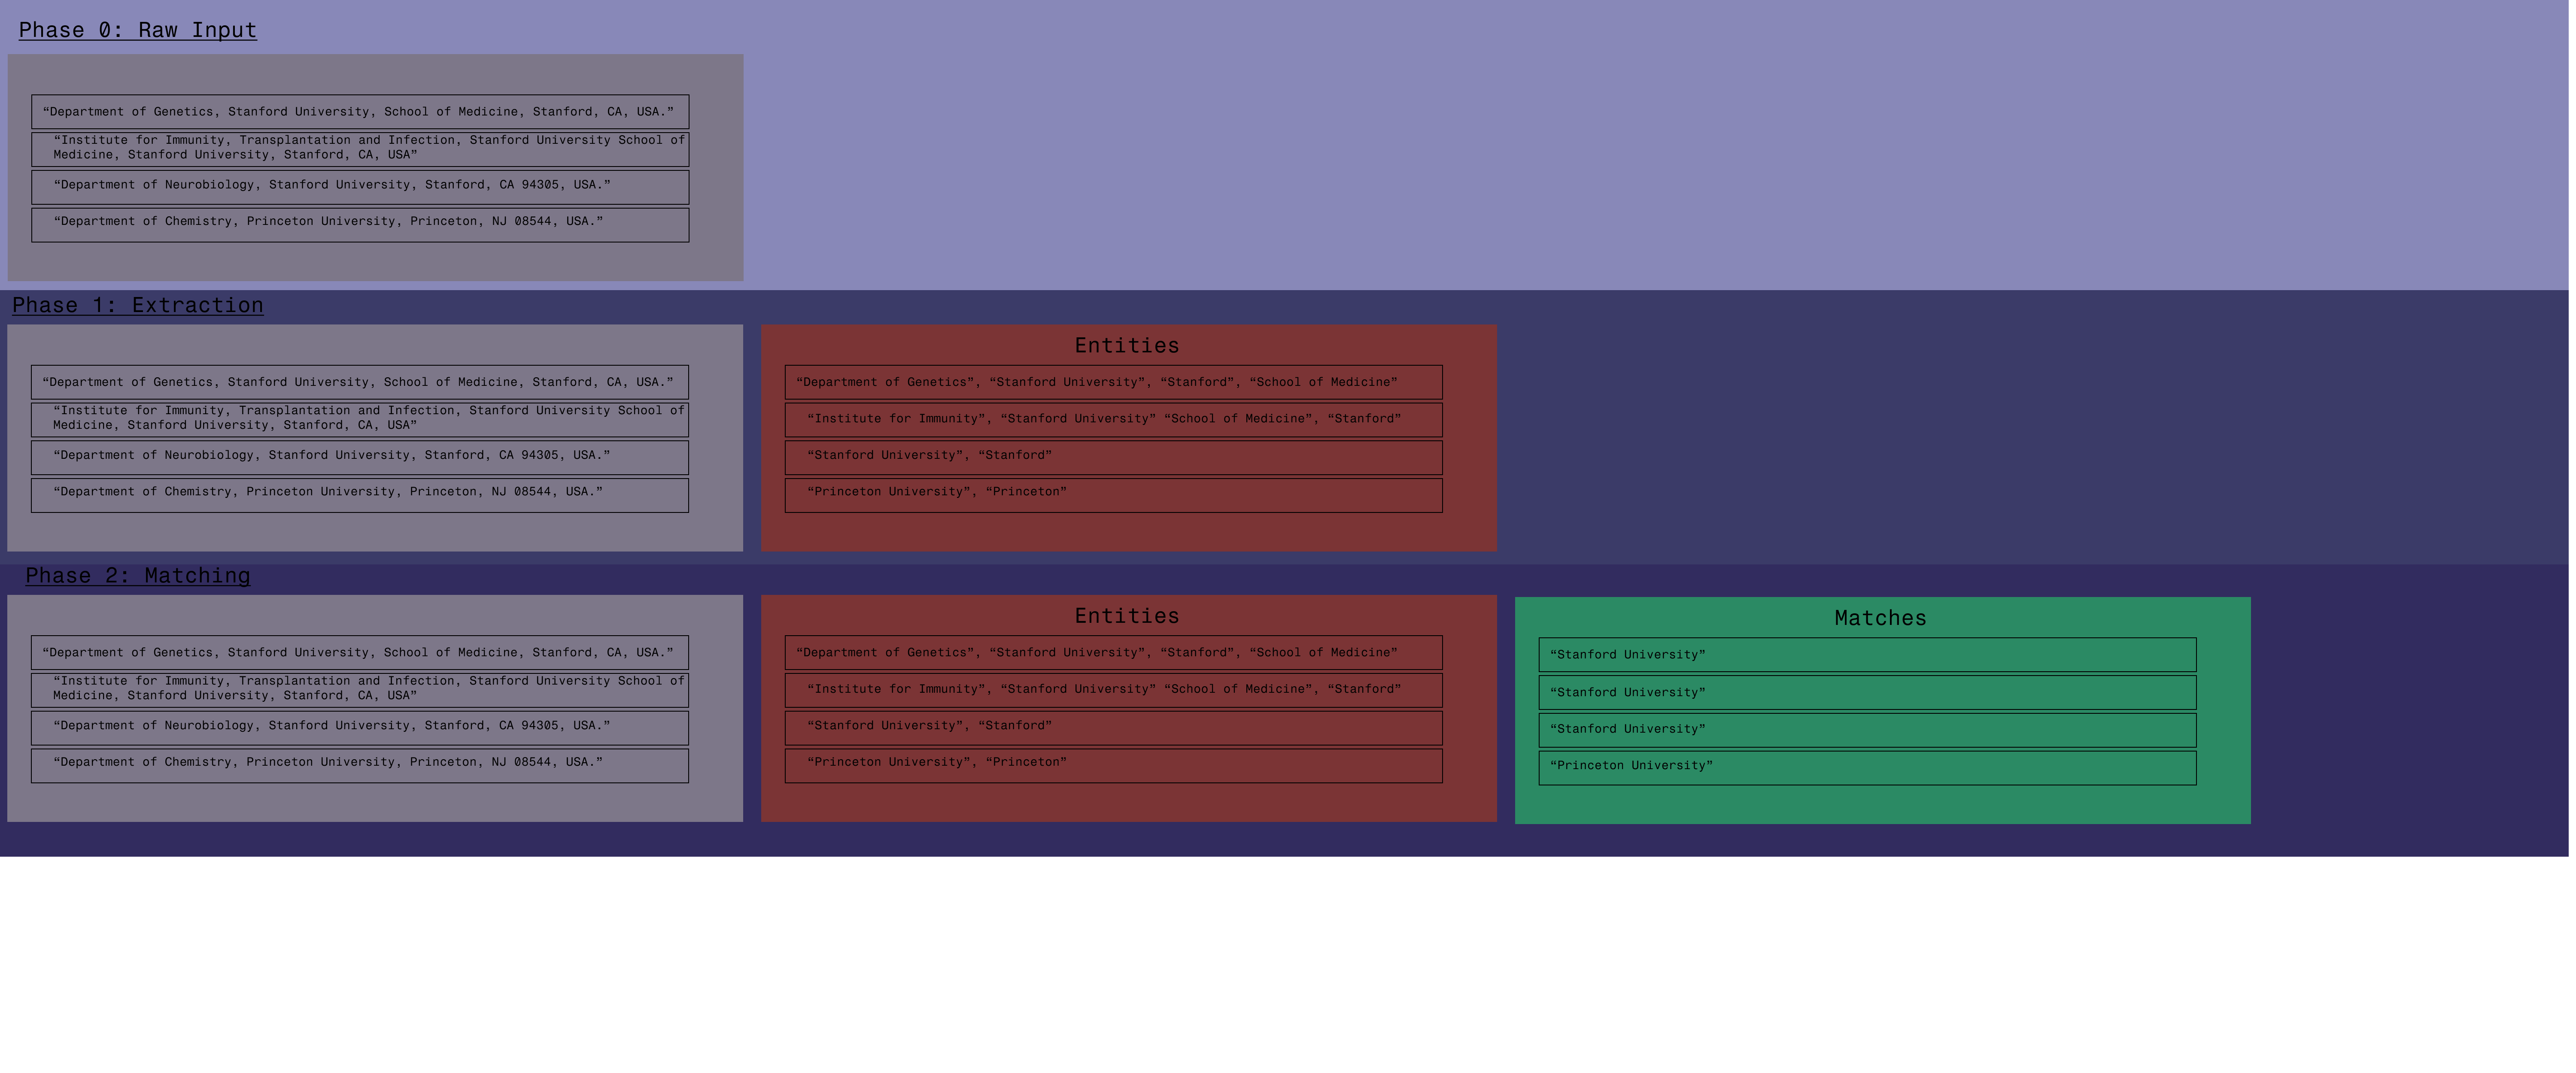

In [35]:
from IPython.display import Image
Image(filename='phases.png') 

In [36]:
print(len(geo_good))
geo_good = geo_good.drop_duplicates(subset=['name'])
print("Reduced to: ")
print(len(geo_good))

3971
Reduced to: 
1868


In [37]:
from relik import Relik
from relik.inference.data.objects import RelikOutput

relik = Relik.from_pretrained("sapienzanlp/relik-entity-linking-large")

                ___              __         
               /\_ \      __    /\ \        
 _ __     __   \//\ \    /\_\   \ \ \/'\    
/\`'__\ /'__`\   \ \ \   \/\ \   \ \ , <    
\ \ \/ /\  __/    \_\ \_  \ \ \   \ \ \\`\  
 \ \_\ \ \____\   /\____\  \ \_\   \ \_\ \_\
  \/_/  \/____/   \/____/   \/_/    \/_/\/_/
                                            
                                            



/home/aidan/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[2024-11-01 11:53:35,134] [INFO] [relik.inference.annotator.from_pretrained:700] [PID:7148] [RANK:0] Loading Relik from sapienzanlp/relik-entity-linking-large
[2024-11-01 11:53:35,136] [INFO] [relik.inference.annotator.from_pretrained:701] [PID:7148] [RANK:0] {
    '_target_': 'relik.inference.annotator.Relik',
    'index': {
        'span': {
            '_target_': 'relik.retriever.indexers.inmemory.InMemoryDocumentIndex.from_pretrained',
            'name_or_path': 'sapienzanlp/relik-retriever-e5-base-v2-aida-blink-wikipedia-index',
        },
    },
    'metadata_fields': [],
    'reader': {
        '_target_': 'relik.reader.pytorch_modules.span.RelikReaderForSpanExtraction',
        'transformer_model': 'sapienzanlp/relik-reader-deberta-v3-large-aida',
        'use_nme': True,
    },
    'retriever': {
        'span': {
            '_target_': 'relik.retriever.pytorch_modules.model.GoldenRetriever',
            'question_encoder': 'sapienzanlp/relik-retriever-e5-base-v2-aida-blink

/home/aidan/.local/lib/python3.12/site-packages/relik/retriever/indexers/base.py:536: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embedding_path, m

[2024-11-01 11:54:03,511] [INFO] [relik.retriever.indexers.inmemory.__init__:65] [PID:7148] [RANK:0] Both documents and embeddings are provided.
[2024-11-01 11:54:03,512] [INFO] [relik.retriever.indexers.inmemory.__init__:107] [PID:7148] [RANK:0] Index vectors are of type torch.float16 but the device is CPU. Converting to torch.float32.


In [38]:
texts = geo_good['name'].to_list()
RelikOutput = relik(texts)

KeyboardInterrupt: 

In [39]:
counter = 0
listofr = []
for m in texts:
    print(counter, " of ", len(texts))

    mRelikOutput = relik(m)
    id_r = mRelikOutput.candidates.span[0][0][0].id
    tx_r = mRelikOutput.candidates.span[0][0][0].text
    rdc = {"original": geo_good['name'].iloc[counter], "id": id_r, "txt": tx_r}
    listofr.append(rdc)
    counter+=1
    
df3 = pd.json_normalize(listofr) 


0  of  1868
[2024-11-01 12:03:07,343] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1  of  1868
[2024-11-01 12:03:10,954] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
2  of  1868
[2024-11-01 12:03:14,613] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
3  of  1868
[2024-11-01 12:03:17,635] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
4  of  1868
[2024-11-01 12:03:21,244] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
5  of  1868
[2024-11-01 12:03:24,184] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
6  o

47  of  1868
[2024-11-01 12:05:38,895] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
48  of  1868
[2024-11-01 12:05:42,604] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
49  of  1868
[2024-11-01 12:05:46,259] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
50  of  1868
[2024-11-01 12:05:49,433] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
51  of  1868
[2024-11-01 12:05:52,472] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
52  of  1868
[2024-11-01 12:05:55,789] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processe

94  of  1868
[2024-11-01 12:08:08,715] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
95  of  1868
[2024-11-01 12:08:11,826] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
96  of  1868
[2024-11-01 12:08:15,158] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
97  of  1868
[2024-11-01 12:08:18,302] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
98  of  1868
[2024-11-01 12:08:21,580] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
99  of  1868
[2024-11-01 12:08:24,522] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processe

140  of  1868
[2024-11-01 12:10:37,077] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
141  of  1868
[2024-11-01 12:10:40,168] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
142  of  1868
[2024-11-01 12:10:43,328] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
143  of  1868
[2024-11-01 12:10:46,284] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
144  of  1868
[2024-11-01 12:10:49,688] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
145  of  1868
[2024-11-01 12:10:52,642] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

186  of  1868
[2024-11-01 12:13:03,816] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
187  of  1868
[2024-11-01 12:13:06,952] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
188  of  1868
[2024-11-01 12:13:10,083] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
189  of  1868
[2024-11-01 12:13:13,138] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
190  of  1868
[2024-11-01 12:13:16,223] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
191  of  1868
[2024-11-01 12:13:19,548] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

232  of  1868
[2024-11-01 12:15:32,610] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
233  of  1868
[2024-11-01 12:15:35,990] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
234  of  1868
[2024-11-01 12:15:38,901] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
235  of  1868
[2024-11-01 12:15:42,209] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
236  of  1868
[2024-11-01 12:15:45,547] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
237  of  1868
[2024-11-01 12:15:48,638] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

278  of  1868
[2024-11-01 12:18:05,776] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
279  of  1868
[2024-11-01 12:18:08,752] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
280  of  1868
[2024-11-01 12:18:11,638] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
281  of  1868
[2024-11-01 12:18:14,538] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
282  of  1868
[2024-11-01 12:18:18,770] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
283  of  1868
[2024-11-01 12:18:21,745] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

324  of  1868
[2024-11-01 12:20:29,809] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
325  of  1868
[2024-11-01 12:20:32,846] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
326  of  1868
[2024-11-01 12:20:35,773] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
327  of  1868
[2024-11-01 12:20:38,911] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
328  of  1868
[2024-11-01 12:20:41,820] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
329  of  1868
[2024-11-01 12:20:44,726] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

370  of  1868
[2024-11-01 12:22:52,879] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
371  of  1868
[2024-11-01 12:22:55,863] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
372  of  1868
[2024-11-01 12:22:59,203] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
373  of  1868
[2024-11-01 12:23:02,239] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
374  of  1868
[2024-11-01 12:23:05,491] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
375  of  1868
[2024-11-01 12:23:08,962] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

416  of  1868
[2024-11-01 12:25:16,859] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
417  of  1868
[2024-11-01 12:25:20,538] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
418  of  1868
[2024-11-01 12:25:23,630] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
419  of  1868
[2024-11-01 12:25:26,674] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
420  of  1868
[2024-11-01 12:25:29,694] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
421  of  1868
[2024-11-01 12:25:32,642] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

462  of  1868
[2024-11-01 12:27:44,772] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
463  of  1868
[2024-11-01 12:27:48,031] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
464  of  1868
[2024-11-01 12:27:51,342] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
465  of  1868
[2024-11-01 12:27:54,243] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
466  of  1868
[2024-11-01 12:27:57,554] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
467  of  1868
[2024-11-01 12:28:00,937] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

508  of  1868
[2024-11-01 12:30:07,599] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
509  of  1868
[2024-11-01 12:30:10,504] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
510  of  1868
[2024-11-01 12:30:13,445] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
511  of  1868
[2024-11-01 12:30:16,394] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
512  of  1868
[2024-11-01 12:30:21,130] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
513  of  1868
[2024-11-01 12:30:24,291] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

554  of  1868
[2024-11-01 12:32:30,332] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
555  of  1868
[2024-11-01 12:32:33,400] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
556  of  1868
[2024-11-01 12:32:36,311] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
557  of  1868
[2024-11-01 12:32:39,470] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
558  of  1868
[2024-11-01 12:32:42,335] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
559  of  1868
[2024-11-01 12:32:45,382] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

600  of  1868
[2024-11-01 12:34:54,192] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
601  of  1868
[2024-11-01 12:34:57,171] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
602  of  1868
[2024-11-01 12:35:00,212] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
603  of  1868
[2024-11-01 12:35:03,183] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
604  of  1868
[2024-11-01 12:35:06,210] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
605  of  1868
[2024-11-01 12:35:09,224] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

646  of  1868
[2024-11-01 12:37:14,413] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
647  of  1868
[2024-11-01 12:37:17,556] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
648  of  1868
[2024-11-01 12:37:20,494] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
649  of  1868
[2024-11-01 12:37:23,502] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
650  of  1868
[2024-11-01 12:37:26,498] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
651  of  1868
[2024-11-01 12:37:29,598] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

692  of  1868
[2024-11-01 12:39:37,200] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
693  of  1868
[2024-11-01 12:39:40,547] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
694  of  1868
[2024-11-01 12:39:43,833] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
695  of  1868
[2024-11-01 12:39:46,890] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
696  of  1868
[2024-11-01 12:39:49,864] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
697  of  1868
[2024-11-01 12:39:52,882] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

738  of  1868
[2024-11-01 12:41:59,547] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
739  of  1868
[2024-11-01 12:42:02,633] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
740  of  1868
[2024-11-01 12:42:05,897] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
741  of  1868
[2024-11-01 12:42:09,002] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
742  of  1868
[2024-11-01 12:42:12,050] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
743  of  1868
[2024-11-01 12:42:15,088] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

784  of  1868
[2024-11-01 12:44:24,724] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
785  of  1868
[2024-11-01 12:44:27,770] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
786  of  1868
[2024-11-01 12:44:30,924] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
787  of  1868
[2024-11-01 12:44:34,159] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
788  of  1868
[2024-11-01 12:44:37,350] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
789  of  1868
[2024-11-01 12:44:40,593] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

830  of  1868
[2024-11-01 12:46:50,135] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
831  of  1868
[2024-11-01 12:46:53,223] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
832  of  1868
[2024-11-01 12:46:56,491] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
833  of  1868
[2024-11-01 12:46:59,923] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
834  of  1868
[2024-11-01 12:47:03,023] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
835  of  1868
[2024-11-01 12:47:06,074] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

876  of  1868
[2024-11-01 12:49:14,086] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
877  of  1868
[2024-11-01 12:49:17,252] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
878  of  1868
[2024-11-01 12:49:20,528] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
879  of  1868
[2024-11-01 12:49:23,566] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
880  of  1868
[2024-11-01 12:49:27,181] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
881  of  1868
[2024-11-01 12:49:30,430] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

922  of  1868
[2024-11-01 12:51:42,467] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
923  of  1868
[2024-11-01 12:51:45,543] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
924  of  1868
[2024-11-01 12:51:48,594] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
925  of  1868
[2024-11-01 12:51:51,598] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
926  of  1868
[2024-11-01 12:51:54,617] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
927  of  1868
[2024-11-01 12:51:57,817] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

968  of  1868
[2024-11-01 12:54:02,736] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
969  of  1868
[2024-11-01 12:54:05,996] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
970  of  1868
[2024-11-01 12:54:09,357] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
971  of  1868
[2024-11-01 12:54:12,791] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
972  of  1868
[2024-11-01 12:54:16,079] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
973  of  1868
[2024-11-01 12:54:19,391] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements pr

1014  of  1868
[2024-11-01 12:56:24,341] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1015  of  1868
[2024-11-01 12:56:27,402] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1016  of  1868
[2024-11-01 12:56:30,315] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1017  of  1868
[2024-11-01 12:56:33,325] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1018  of  1868
[2024-11-01 12:56:36,512] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1019  of  1868
[2024-11-01 12:56:39,595] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1060  of  1868
[2024-11-01 12:58:50,162] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1061  of  1868
[2024-11-01 12:58:53,240] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1062  of  1868
[2024-11-01 12:58:56,323] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1063  of  1868
[2024-11-01 12:58:59,308] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1064  of  1868
[2024-11-01 12:59:02,316] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1065  of  1868
[2024-11-01 12:59:05,302] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1106  of  1868
[2024-11-01 13:01:12,686] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1107  of  1868
[2024-11-01 13:01:15,628] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1108  of  1868
[2024-11-01 13:01:18,645] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1109  of  1868
[2024-11-01 13:01:21,787] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1110  of  1868
[2024-11-01 13:01:25,009] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1111  of  1868
[2024-11-01 13:01:28,131] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1152  of  1868
[2024-11-01 13:03:39,292] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1153  of  1868
[2024-11-01 13:03:42,718] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1154  of  1868
[2024-11-01 13:03:45,786] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1155  of  1868
[2024-11-01 13:03:49,099] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1156  of  1868
[2024-11-01 13:03:52,236] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1157  of  1868
[2024-11-01 13:03:55,576] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1198  of  1868
[2024-11-01 13:06:05,098] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1199  of  1868
[2024-11-01 13:06:08,012] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1200  of  1868
[2024-11-01 13:06:11,120] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1201  of  1868
[2024-11-01 13:06:14,058] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1202  of  1868
[2024-11-01 13:06:17,052] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1203  of  1868
[2024-11-01 13:06:20,137] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1244  of  1868
[2024-11-01 13:08:26,488] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1245  of  1868
[2024-11-01 13:08:29,573] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1246  of  1868
[2024-11-01 13:08:32,830] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1247  of  1868
[2024-11-01 13:08:35,894] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1248  of  1868
[2024-11-01 13:08:39,035] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1249  of  1868
[2024-11-01 13:08:42,110] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1290  of  1868
[2024-11-01 13:10:51,168] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1291  of  1868
[2024-11-01 13:10:54,320] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1292  of  1868
[2024-11-01 13:10:57,253] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1293  of  1868
[2024-11-01 13:11:00,233] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1294  of  1868
[2024-11-01 13:11:03,196] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1295  of  1868
[2024-11-01 13:11:06,166] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1336  of  1868
[2024-11-01 13:13:11,218] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1337  of  1868
[2024-11-01 13:13:14,376] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1338  of  1868
[2024-11-01 13:13:18,920] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
1339  of  1868
[2024-11-01 13:13:22,159] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1340  of  1868
[2024-11-01 13:13:25,432] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1341  of  1868
[2024-11-01 13:13:28,928] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1382  of  1868
[2024-11-01 13:15:35,103] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1383  of  1868
[2024-11-01 13:15:38,282] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1384  of  1868
[2024-11-01 13:15:41,553] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1385  of  1868
[2024-11-01 13:15:45,031] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1386  of  1868
[2024-11-01 13:15:48,294] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1387  of  1868
[2024-11-01 13:15:51,512] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1428  of  1868
[2024-11-01 13:18:02,041] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1429  of  1868
[2024-11-01 13:18:05,198] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1430  of  1868
[2024-11-01 13:18:08,278] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1431  of  1868
[2024-11-01 13:18:11,146] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1432  of  1868
[2024-11-01 13:18:14,242] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1433  of  1868
[2024-11-01 13:18:17,210] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1474  of  1868
[2024-11-01 13:20:25,745] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1475  of  1868
[2024-11-01 13:20:28,724] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1476  of  1868
[2024-11-01 13:20:31,680] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1477  of  1868
[2024-11-01 13:20:34,802] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1478  of  1868
[2024-11-01 13:20:37,724] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1479  of  1868
[2024-11-01 13:20:40,706] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1520  of  1868
[2024-11-01 13:22:50,629] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1521  of  1868
[2024-11-01 13:22:53,761] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1522  of  1868
[2024-11-01 13:22:56,802] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1523  of  1868
[2024-11-01 13:22:59,806] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1524  of  1868
[2024-11-01 13:23:02,693] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1525  of  1868
[2024-11-01 13:23:05,997] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1566  of  1868
[2024-11-01 13:25:18,150] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1567  of  1868
[2024-11-01 13:25:21,177] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1568  of  1868
[2024-11-01 13:25:24,141] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1569  of  1868
[2024-11-01 13:25:27,137] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1570  of  1868
[2024-11-01 13:25:30,106] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1571  of  1868
[2024-11-01 13:25:33,274] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1612  of  1868
[2024-11-01 13:27:41,690] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1613  of  1868
[2024-11-01 13:27:45,068] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1614  of  1868
[2024-11-01 13:27:48,315] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1615  of  1868
[2024-11-01 13:27:51,580] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1616  of  1868
[2024-11-01 13:27:54,908] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1617  of  1868
[2024-11-01 13:27:57,981] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1658  of  1868
[2024-11-01 13:30:07,980] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1659  of  1868
[2024-11-01 13:30:10,893] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1660  of  1868
[2024-11-01 13:30:13,911] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1661  of  1868
[2024-11-01 13:30:16,959] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1662  of  1868
[2024-11-01 13:30:19,931] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1663  of  1868
[2024-11-01 13:30:23,148] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1704  of  1868
[2024-11-01 13:32:33,052] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1705  of  1868
[2024-11-01 13:32:36,045] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1706  of  1868
[2024-11-01 13:32:39,030] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1707  of  1868
[2024-11-01 13:32:42,197] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1708  of  1868
[2024-11-01 13:32:45,387] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1709  of  1868
[2024-11-01 13:32:48,359] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1750  of  1868
[2024-11-01 13:34:58,459] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1751  of  1868
[2024-11-01 13:35:01,511] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1752  of  1868
[2024-11-01 13:35:04,725] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1753  of  1868
[2024-11-01 13:35:07,725] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1754  of  1868
[2024-11-01 13:35:11,885] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of elements processed
1755  of  1868
[2024-11-01 13:35:15,104] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

1796  of  1868
[2024-11-01 13:37:20,643] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1797  of  1868
[2024-11-01 13:37:23,495] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1798  of  1868
[2024-11-01 13:37:26,753] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1799  of  1868
[2024-11-01 13:37:30,112] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1800  of  1868
[2024-11-01 13:37:33,524] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1801  of  1868
[2024-11-01 13:37:37,762] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 2 number of eleme

1842  of  1868
[2024-11-01 13:39:46,558] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1843  of  1868
[2024-11-01 13:39:49,549] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1844  of  1868
[2024-11-01 13:39:52,560] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1845  of  1868
[2024-11-01 13:39:55,560] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1846  of  1868
[2024-11-01 13:39:58,551] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of elements processed
1847  of  1868
[2024-11-01 13:40:01,605] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:7148] [RANK:0] Dataset finished: 1 number of eleme

In [40]:
df3.to_pickle('relikApplied.pkl')    #to save the dataframe, df to 123.pkl


## GliNER

[GLiNER: Generalist Model for Named Entity Recognition using Bidirectional Transformer by Zaratiana et. al](https://arxiv.org/pdf/2311.08526) presents an open named entity resolution model which matches text to a set of natural language entity tags provided at inference time. 

In [ ]:
#Load Spacy+Gliner Pipeline Pipeline
nlp = spacy.blank("en")
#add configs (University, School, Organization)
custom_spacy_config = { "gliner_model": "urchade/gliner_multi",
                            "chunk_size": 250,
                            "labels": ["university", "school", "organization"],
                            "style": "ent"}
nlp.add_pipe("gliner_spacy", config=custom_spacy_config)

In [ ]:
texts = geo_good['name'].to_list()


In [ ]:
tagged_schools = []
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    ents_schools = [ent.text for ent in doc.ents if ent.label_ == 'university' or ent.label_ == 'school']
    #if university or school is identified, append to the list
    if(len(ents_schools) >= 1):
        tagged_schools.append(ents_schools)
    #if a university or school is not identified, look for organizations
    else:
        ents_orgs = [ent.text for ent in doc.ents if ent.label_ == 'organization']
        if(len(ents_orgs)>=1):
            tagged_schools.append(ents_orgs)
    #this should just append the actual text itself if no entities are extracted
    # - if a department entity is included it will use that first
    if(len(ents_schools) == 0 and len(ents_orgs) == 0):
        ents_orgs = [ent.text for ent in doc.ents if ent.label_ == 'department']
        if(len(ents_orgs) != 0):
            tagged_schools.append(ents_orgs)
        elif (len(ents_orgs) == 0):
            tagged_schools.append([doc.text])


In [ ]:
print(tagged_schools)

In [ ]:
from relik import Relik
from relik.inference.data.objects import RelikOutput

relik = Relik.from_pretrained("sapienzanlp/relik-entity-linking-large")


In [ ]:
RelikOutput = relik(texts)

In [ ]:
print(len(RelikOutput.candidates.span))
print((RelikOutput.candidates.span[0][0][0]))
print(type(RelikOutput.candidates.span[0][0][0]))
print(dir(RelikOutput.candidates.span[0][0][0]))
print((RelikOutput.candidates.span[0][0][0].id))
print((RelikOutput.candidates.span[0][0][0].text))

## [ReLik](https://arxiv.org/pdf/2408.00103)

In [ ]:
match_tagged = []
exception_count = 0
for i in range(0, len(texts)):
    try:
        RelikOutput = relik(texts)
        id_r = RelikOutput.candidates.span[0][0][0].id
        tx_r = RelikOutput.candidates.span[0][0][0].text
        linkedE = {"entityID": id_r, "entityText": tx_r}
        match_tagged.append(linkedE)
    except Exception as e:
        if(len(tagged_schools[i])!=0):
            linkedE = {"entityID": "NAN", "entityText": tagged_schools[i][0]}
            match_tagged.append(linkedE)
            exception_count+=1
        else:
            linkedE = {"entityID": "NAN", "entityText": "NAN"}
            match_tagged.append(linkedE)
            exception_count+=1


    

In [ ]:
print(match_tagged)

In [ ]:
df3 = pd.json_normalize(match_tagged) 

In [ ]:
df3.head()

In [ ]:
df3.describe()

In [ ]:
df3['entityText'].describe()

In [ ]:
df3['entityText'].describe()

In [ ]:
df4 = pd.concat([geo_good, df3], axis=1)


In [ ]:
df4.to_pickle('relikApplied.pkl')    #to save the dataframe, df to 123.pkl


In [ ]:
df4.head()

In [ ]:
df4.describe()